<a href="https://colab.research.google.com/github/shyamvalsan/neural-murals/blob/main/NeuralMurals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install image_slicer
!pip install image_slicer

     |████████████████████████████████| 2.2MB 3.0MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [ ]:
# Download VGG19 Model
!wget -c https://web.eecs.umich.edu/~justincj/models/vgg19-d01eb7cb.pth
!mkdir models
!cp vgg19-d01eb7cb.pth models/

# Download Images
!wget -c https://github.com/iamRusty/neural-style-pytorch/archive/master.zip
!unzip -q master.zip
!mkdir images
!cp neural-style-pytorch-master/images/1-content.png images
!cp neural-style-pytorch-master/images/1-style.jpg images

--2020-10-03 17:11:02--  https://web.eecs.umich.edu/~justincj/models/vgg19-d01eb7cb.pth
Resolving web.eecs.umich.edu (web.eecs.umich.edu)... 141.212.113.214
Connecting to web.eecs.umich.edu (web.eecs.umich.edu)|141.212.113.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 574689280 (548M) [application/x-tar]
Saving to: ‘vgg19-d01eb7cb.pth’

vgg19-d01eb7cb.pth  100%[===================>] 548.07M  16.0MB/s    in 36s     

2020-10-03 17:11:40 (15.1 MB/s) - ‘vgg19-d01eb7cb.pth’ saved [574689280/574689280]

--2020-10-03 17:11:42--  https://github.com/iamRusty/neural-style-pytorch/archive/master.zip
Resolving github.com (github.com)... 13.114.40.48
Connecting to github.com (github.com)|13.114.40.48|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/rrmina/neural-style-pytorch/archive/master.zip [following]
--2020-10-03 17:11:42--  https://github.com/rrmina/neural-style-pytorch/archive/master.zip
Reusing ex

In [ ]:
# Import!
import torch
import torch.nn as nn
import torch.optim as optim

import copy
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms

import cv2
import copy
from PIL import Image
from google.colab import files

import scipy
from imageio import imwrite
from imageio import imread
from scipy import ndimage
from scipy import misc
import scipy.misc
import image_slicer
from image_slicer import join


In [ ]:
# Upload content
uploaded = files.upload()

Saving yellow.JPG to yellow.JPG


In [ ]:
# Upload style 
uploaded = files.upload()

Saving style1.png to style1.png


In [ ]:
# Hyperparameters
MAX_IMAGE_SIZE = 1024
NUM_TILES = 12

# Optimizer
OPTIMIZER = 'adam' #or 'lbfgs'
ADAM_LR = 10
CONTENT_WEIGHT = 5e0
STYLE_WEIGHT = 1e2
TV_WEIGHT = 1e-3
NUM_ITER = 500
SHOW_ITER = 500

# Image Files
INIT_IMAGE = 'content' # or 'content'
PRESERVE_COLOR = 'False' # 'False'
PIXEL_CLIP = 'True' # or 'False' - Clipping produces better images
CONTENT_PATH = 'yellow.JPG'
STYLE_PATH = 'style1.png'

"""
PRETRAINED VGG MODELS 
GITHUB REPO: https://github.com/jcjohnson/pytorch-vgg
VGG 19: https://web.eecs.umich.edu/~justincj/models/vgg19-d01eb7cb.pth
VGG 16: https://web.eecs.umich.edu/~justincj/models/vgg16-00b39a1b.pth
"""
VGG19_PATH = 'models/vgg19-d01eb7cb.pth'
POOL = 'max'

In [ ]:
# Print the device
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# Load image file
def load_image(path):
    # Images loaded as BGR
    img = cv2.imread(path)
    return img

# Show image
def show(img):
    # Convert from BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # imshow() only accepts float [0,1] or int [0,255]
    img = np.array(img/255).clip(0,1)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.show()
    
# Save Image as out{num_iterms}.png
def saveimg(img, iters):
    if (PIXEL_CLIP=='True'):
        img = img.clip(0, 255)
    cv2.imwrite('out'+str(iters)+'.png', img)
    
# Color transfer
def transfer_color(src, dest):
    if (PIXEL_CLIP=='True'):
        src, dest = src.clip(0,255), dest.clip(0,255)
        
    # Resize src to dest's size
    H,W,_ = src.shape 
    dest = cv2.resize(dest, dsize=(W, H), interpolation=cv2.INTER_CUBIC)
    
    dest_gray = cv2.cvtColor(dest, cv2.COLOR_BGR2GRAY) #1 Extract the Destination's luminance
    src_yiq = cv2.cvtColor(src, cv2.COLOR_BGR2YCrCb)   #2 Convert the Source from BGR to YIQ/YCbCr
    src_yiq[...,0] = dest_gray                         #3 Combine Destination's luminance and Source's IQ/CbCr
    
    return cv2.cvtColor(src_yiq, cv2.COLOR_YCrCb2BGR)  #4 Convert new image from YIQ back to BGR


In [ ]:
# Preprocessing
def itot(img):
    # Rescale the image
    H, W, C = img.shape
    image_size = tuple([int((float(MAX_IMAGE_SIZE) / max([H,W]))*x) for x in [H, W]])
    
    itot_t = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(image_size),
        transforms.ToTensor()
    ])
    
    # Subtract the means
    normalize_t = transforms.Normalize([103.939, 116.779, 123.68],[1,1,1])
    tensor = normalize_t(itot_t(img)*255)
    
    # Add the batch_size dimension
    tensor = tensor.unsqueeze(dim=0)
    return tensor

def ttoi(tensor):
    # Add the means
    ttoi_t = transforms.Compose([
        transforms.Normalize([-103.939, -116.779, -123.68],[1,1,1])])
    
    # Remove the batch_size dimension
    tensor = tensor.squeeze()
    img = ttoi_t(tensor)
    img = img.cpu().numpy()
    
    # Transpose from [C, H, W] -> [H, W, C]
    img = img.transpose(1, 2, 0)
    return img

In [ ]:
# Load VGG19 Skeleton
vgg = models.vgg19(pretrained=False)

# Load pretrained weights
vgg.load_state_dict(torch.load(VGG19_PATH), strict=False)

# Change Pooling Layer
def pool_(model, pool='avg'):
    if (pool=='avg'):
        ct=0
        for layer in model.children():
            if isinstance(layer, nn.MaxPool2d):
                model[ct] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
            ct+=1
    elif (pool=='max'):
        ct=0
        for layer in model.children():
            if isinstance(layer, nn.AvgPool2d):
                model[ct] = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
            ct+=1
            
    return model

#vgg.features = pool_(vgg.features, POOL)

# Extract only the 'features' network, 
# 'classifier' network is not needed
model = copy.deepcopy(vgg.features)
model.to(device)

# Turn-off unnecessary gradient tracking
for param in model.parameters():
    param.requires_grad = False

In [ ]:
mse_loss = torch.nn.MSELoss()
def gram(tensor):
    B, C, H, W = tensor.shape
    x = tensor.view(C, H*W)
    return torch.mm(x, x.t())

def content_loss(g, c):
    loss = mse_loss(g, c)
    return loss
    
def style_loss(g, s):
    c1,c2 = g.shape
    loss = mse_loss(g, s)
    return loss / (c1**2) # Divide by square of channels

def tv_loss(c):
    x = c[:,:,1:,:] - c[:,:,:-1,:]
    y = c[:,:,:,1:] - c[:,:,:,:-1]
    loss = torch.sum(torch.abs(x)) + torch.sum(torch.abs(y))
    return loss

In [ ]:
# VGG Forward Pass
def get_features(model, tensor):
    layers = {
        '3': 'relu1_2',   # Style layers
        '8': 'relu2_2',
        '17' : 'relu3_3',
        '26' : 'relu4_3',
        '35' : 'relu5_3',
        '22' : 'relu4_2', # Content layers
        #'31' : 'relu5_2'
    }
    
    # Get features
    features = {}
    x = tensor
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            if (name=='22'):   # relu4_2
                features[layers[name]] = x
            elif (name=='31'): # relu5_2
                features[layers[name]] = x
            else:
                b, c, h, w = x.shape
                features[layers[name]] = gram(x) / (h*w)
                
            # Terminate forward pass
            if (name == '35'):
                break
            
    return features

In [ ]:
# Generate Initial Image
def initial(content_tensor, init_image='random'):
    B, C, H, W = content_tensor.shape
    if (init_image=='random'):
        #tensor = torch.randn(C, H, W).mul(torch.std(content_tensor.clone().cpu())/255).unsqueeze(0)
        tensor = torch.randn(C, H, W).mul(0.001).unsqueeze(0)
    else:
        tensor = content_tensor.clone().detach()
    
    return tensor



In [ ]:
def stylize(iteration=NUM_ITER):     
    # Get features representations/Forward pass
    content_layers = ['relu4_2']
    content_weights = {'relu4_2': 1.0} 
    style_layers = ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3']
    style_weights = {'relu1_2': 0.2, 'relu2_2': 0.2, 'relu3_3': 0.2, 'relu4_3': 0.2, 'relu5_3': 0.2}
    c_feat = get_features(model, content_tensor)
    s_feat = get_features(model, style_tensor)
    
    i = [0]
    while i[0] < iteration:
        def closure():
            # Zero-out gradients
            optimizer.zero_grad()

            # Forward pass
            g_feat = get_features(model, g)

            # Compute Losses
            c_loss=0
            s_loss=0
            for j in content_layers:
                c_loss += content_weights[j] * content_loss(g_feat[j], c_feat[j])
            for j in style_layers:
                s_loss += style_weights[j] * style_loss(g_feat[j], s_feat[j])
            
            c_loss = CONTENT_WEIGHT * c_loss
            s_loss = STYLE_WEIGHT * s_loss
            t_loss = TV_WEIGHT * tv_loss(g.clone().detach())
            total_loss = c_loss + s_loss + t_loss

            # Backprop
            total_loss.backward(retain_graph=True)
            
            # Print Loss, show and save image
            i[0]+=1
            if (((i[0] % SHOW_ITER) == 1) or (i[0]==NUM_ITER)):
                print("Style Loss: {} Content Loss: {} TV Loss: {} Total Loss : {}".format(s_loss.item(), c_loss.item(), t_loss, total_loss.item()))
                if (PRESERVE_COLOR=='True'):
                    g_ = transfer_color(ttoi(content_tensor.clone().detach()), ttoi(g.clone().detach()))
                else:
                    g_ = ttoi(g.clone().detach())
                show(g_)
                saveimg(g_, i[0]-1)
                #plt.show()
            
            return (total_loss)
        
        # Weight/Pixel update
        optimizer.step(closure)

    return g

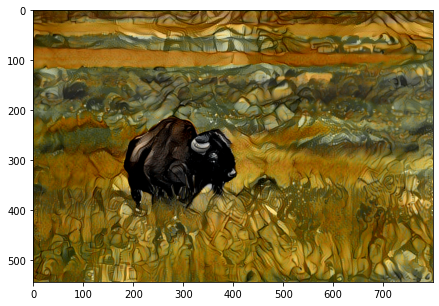

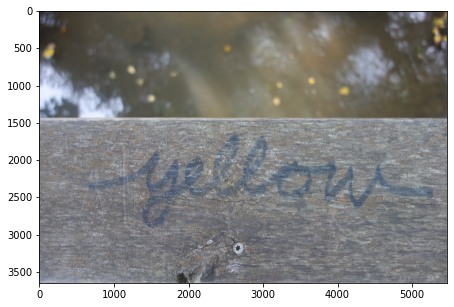

In [ ]:
# Load Images
content_img = load_image(CONTENT_PATH)
style_img = load_image(STYLE_PATH)  

# Split Content
tiles = image_slicer.slice(CONTENT_PATH, NUM_TILES)

# Show Images
show(style_img)
show(content_img)

yellow_01_01.png
Style Loss: 33053672.0 Content Loss: 0.0 TV Loss: 9061.4619140625 Total Loss : 33062734.0


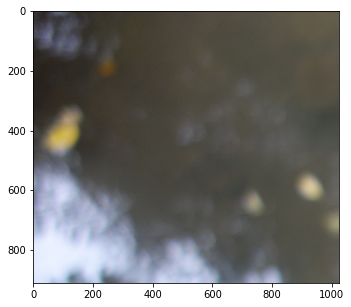

Style Loss: 99171.5546875 Content Loss: 537558.1875 TV Loss: 88379.703125 Total Loss : 725109.4375


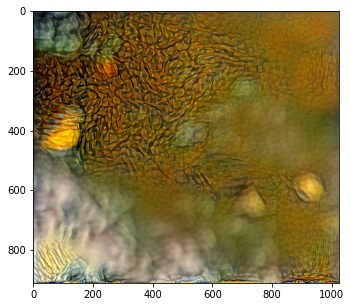

yellow_01_02.png
Style Loss: 34725708.0 Content Loss: 0.0 TV Loss: 7215.01025390625 Total Loss : 34732924.0


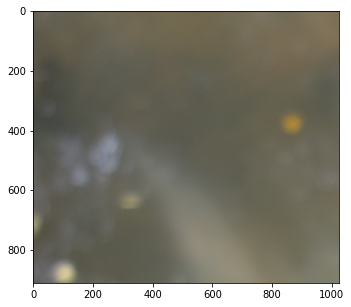

Style Loss: 102053.3046875 Content Loss: 500328.4375 TV Loss: 89116.515625 Total Loss : 691498.25


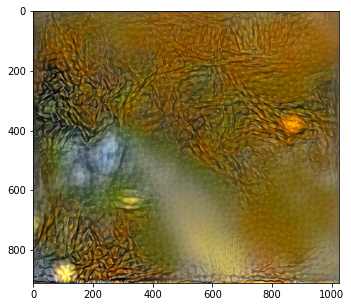

yellow_01_03.png
Style Loss: 34540232.0 Content Loss: 0.0 TV Loss: 6994.525390625 Total Loss : 34547228.0


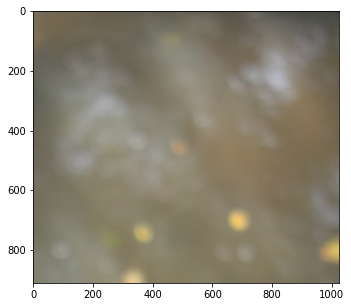

Style Loss: 176820.640625 Content Loss: 477276.21875 TV Loss: 89492.390625 Total Loss : 743589.25


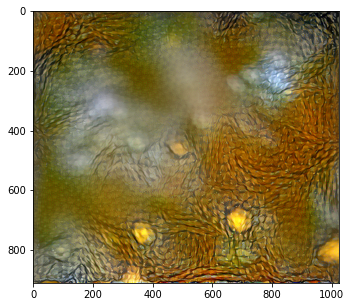

yellow_01_04.png
Style Loss: 32912528.0 Content Loss: 0.0 TV Loss: 8475.9072265625 Total Loss : 32921004.0


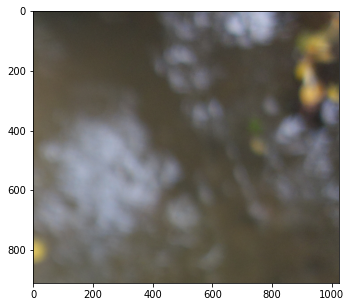

Style Loss: 250550.5625 Content Loss: 650779.6875 TV Loss: 90805.1953125 Total Loss : 992135.4375


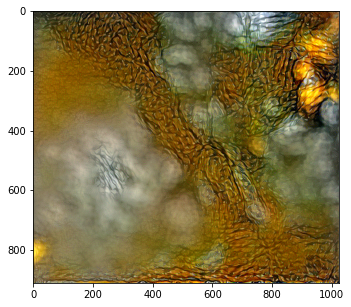

yellow_02_01.png
Style Loss: 29157716.0 Content Loss: 0.0 TV Loss: 30734.65625 Total Loss : 29188450.0


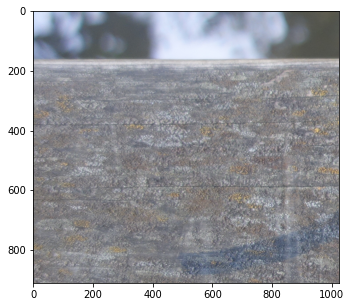

Style Loss: 216871.75 Content Loss: 530540.75 TV Loss: 103019.8125 Total Loss : 850432.3125


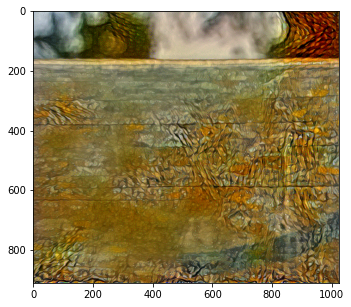

yellow_02_02.png
Style Loss: 28184054.0 Content Loss: 0.0 TV Loss: 37399.96875 Total Loss : 28221454.0


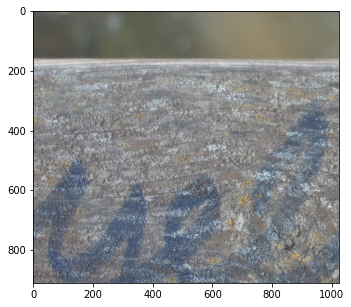

Style Loss: 358016.25 Content Loss: 596874.75 TV Loss: 97170.53125 Total Loss : 1052061.5


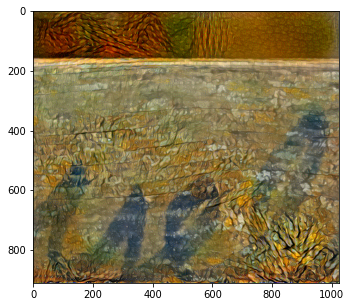

yellow_02_03.png
Style Loss: 29134476.0 Content Loss: 0.0 TV Loss: 33548.9765625 Total Loss : 29168024.0


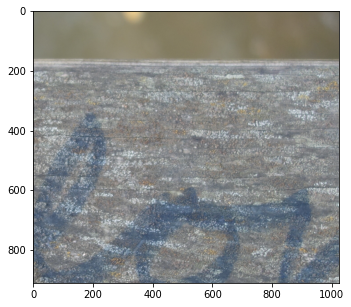

Style Loss: 138424.609375 Content Loss: 494772.75 TV Loss: 93255.3046875 Total Loss : 726452.6875


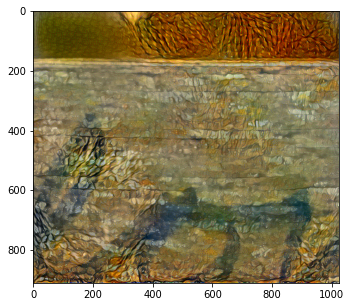

yellow_02_04.png
Style Loss: 29576438.0 Content Loss: 0.0 TV Loss: 29580.173828125 Total Loss : 29606018.0


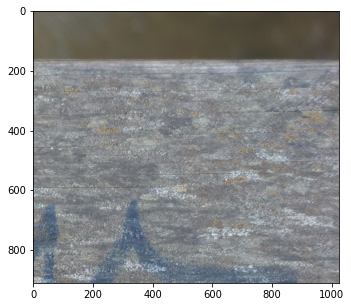

Style Loss: 291332.65625 Content Loss: 498264.5 TV Loss: 91567.125 Total Loss : 881164.25


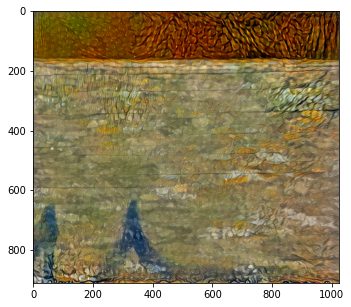

yellow_03_01.png
Style Loss: 29243534.0 Content Loss: 0.0 TV Loss: 41001.16015625 Total Loss : 29284536.0


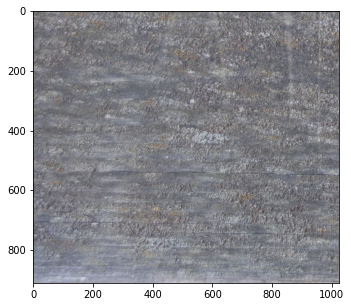

Style Loss: 116067.2578125 Content Loss: 511324.125 TV Loss: 103585.9375 Total Loss : 730977.3125


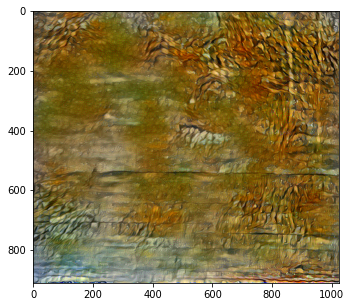

yellow_03_02.png
Style Loss: 27673284.0 Content Loss: 0.0 TV Loss: 47863.5078125 Total Loss : 27721148.0


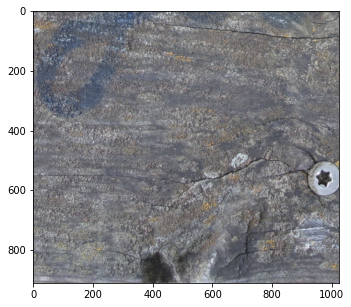

Style Loss: 84863.9921875 Content Loss: 443720.375 TV Loss: 99676.1171875 Total Loss : 628260.5


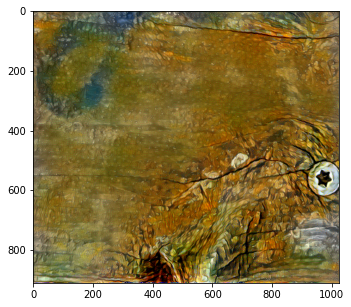

yellow_03_03.png
Style Loss: 29004028.0 Content Loss: 0.0 TV Loss: 40045.03515625 Total Loss : 29044074.0


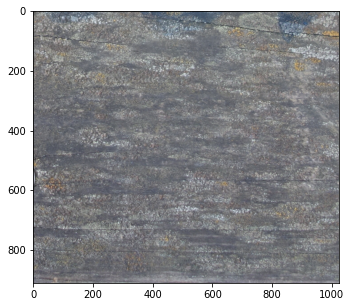

Style Loss: 93748.53125 Content Loss: 465866.28125 TV Loss: 100027.84375 Total Loss : 659642.625


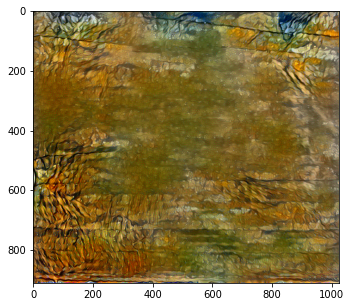

yellow_03_04.png
Style Loss: 29693782.0 Content Loss: 0.0 TV Loss: 36089.390625 Total Loss : 29729872.0


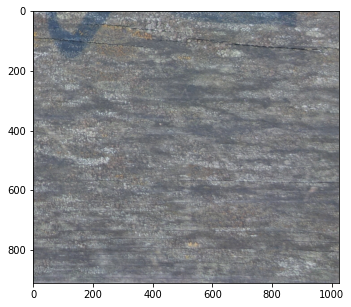

Style Loss: 254155.6875 Content Loss: 454526.4375 TV Loss: 101705.578125 Total Loss : 810387.6875


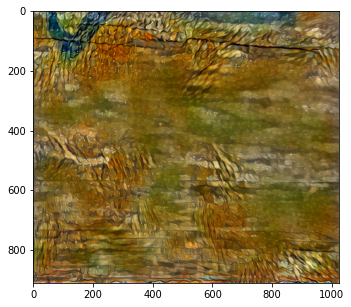

In [ ]:
# Stylize each image tile
style_tensor = itot(style_img).to(device)

for tile in tiles:
  print(tile.filename)
  img1 = load_image(tile.filename)
  content_tensor = itot(img1).to(device)
  g = initial(content_tensor, init_image=INIT_IMAGE)
  g = g.to(device).requires_grad_(True)
  optimizer = optim.Adam([g], lr=ADAM_LR)
  out = stylize(iteration=NUM_ITER)
  saveimg(ttoi(g.clone().detach()), NUM_ITER)
  imgnew = load_image('out500.png')
  cv2.imwrite(tile.filename,imgnew)
  tile.image = Image.open(tile.filename)

In [ ]:
# Join tiles to form final image
!if [ -d "splittiles" ]; then rm -Rf "splittiles"; fi
!mkdir -p "splittiles" 

In [ ]:
import glob, os, shutil

files = glob.iglob(os.path.join(".", "yellow_*.png"))
for file in files:
    if os.path.isfile(file):
        shutil.copy2(file, "splittiles")

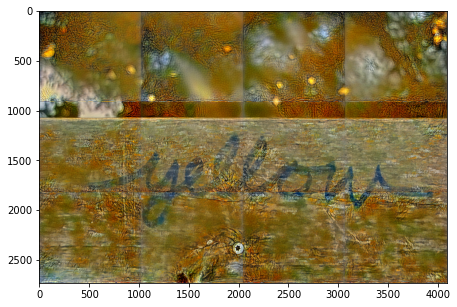

In [ ]:
# Join tiles to form final image
tiles = image_slicer.open_images_in("splittiles")
image = image_slicer.join(tiles)
image.save('final.png')
image1 = load_image('final.png')
show(image1)

In [ ]:
# Download final image
from google.colab import files
files.download("vangogh_01_01.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("vangogh_01_02.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("vangogh_02_01.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("vangogh_16.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>